### XGBoost_Respiratorio e Digestivo_AD03out

### 1) fonte de dados / doenças = arquivo SIH
### 2) doenças alvo = respiratórias e digestivas
### 3) arquivo usado entorno02.
### 4) Muitos dados nulos -- poucas colunas com médias significativas
## Trajetória: saber se teremos doença resp ou digest dependendo das variáveis ambientais
### Preparação do arquivo de dados -- junção de duas bases, divisão em treino e teste, aplicação do XGBoost
### Uso para regressão logística -- matriz de confusão

## bibliotecas a serem usadas

In [1]:
import plotly_express as px
# biblioteca nova, para visualização com diferentes formas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [2]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

# arquivo dados_SIH_SP_2017

In [20]:
df=pd.read_csv('b_17.csv',encoding = "ISO-8859-1", low_memory=False, nrows=100000)
# somente 100 mil linhas, tempo computação adequável

In [21]:
df.head()

gid   uf_zi  ano_cmpt  mes_cmpt  espec  cgc_hosp          n_aih  ident  \
0    1  350000      2017         1      3       NaN  3517107468424      1   
1    2  350000      2017         1      3       NaN  3517107468457      1   
2    3  350000      2017         1      3       NaN  3517107468512      1   
3    4  350000      2017         1      3       NaN  3517107468600      1   
4    5  350000      2017         1      3       NaN  3517107468622      1   

       cep  munic_res      nasc  sexo  uti_mes_in  uti_mes_an  uti_mes_al  \
0  8665480     355250  19800326     1           0           0           0   
1  3577030     355030  19800908     1           0           0           0   
2  1446010     355030  19580308     1           0           0           0   
3  5159180     355030  20050108     3           0           0           0   
4  8830290     353060  19581011     3           0           0           0   

   uti_mes_to  marca_uti  uti_int_in  uti_int_an  uti_int_al  uti_int_to  \
0           0          0           0           0           0           0   
1           0          0           0           0           0           0   
2           0          0           0           0           0           0   
3           0          0           0           0           0           0   
4           0          0           0           0           0           0   

   diar_acom  qt_diarias  proc_solic   proc_rea  val_sh  val_sp  val_sadt  \
0          0           1   303040289  303040289  240.63   63.17         0   
1          0           1   305020021  305020021  426.46   26.77         0   
2          0           1   303060026  303060026  281.34   84.43         0   
3          2           2   304100013  304100013  252.79   16.30         0   
4          0           1   301060088  301060088   33.34   10.88         0   

   val_rn  val_acomp  val_ortp  val_sangue  val_sadtsr  val_transp  \
0       0          0         0           0           0           0   
1       0          0         0           0           0           0   
2       0          0         0           0           0           0   
3       0          0         0           0           0           0   
4       0          0         0           0           0           0   

   val_obsang  val_ped1ac  val_tot  val_uti  us_tot  dt_inter  dt_saida  \
0           0           0   303.80      0.0   98.31  20170109  20170109   
1           0           0   453.23      0.0  146.67  20170102  20170103   
2           0           0   365.77      0.0  118.37  20170103  20170104   
3           0           0   269.09      0.0   87.08  20170102  20170104   
4           0           0    44.22      0.0   14.31  20170111  20170111   

  diag_princ  diag_secun  cobranca  natureza  nat_jur  gestao  rubrica  \
0        G35           0        12         0     1112       2        0   
1       N200           0        15         0     1112       2        0   
2        I48           0        15         0     1112       2        0   
3       C400           0        12         0     1112       2        0   
4       M751           0        15         0     1112       2        0   

   ind_vdrl  munic_mov  cod_idade  idade  dias_perm  morte  nacional  \
0         0     355030          4     36          0      0        10   
1         0     355030          4     36          1      0        10   
2         0     355030          4     58          1      0        10   
3         0     355030          4     11          2      0        10   
4         0     355030          4     58          0      0        10   

   num_proc  car_int  tot_pt_sp  cpf_aut  homonimo  num_filhos  instru  \
0       NaN        1          0      NaN         0           0       0   
1       NaN        1          0      NaN         0           0       0   
2       NaN        2          0      NaN         0           0       0   
3       NaN        2          0      NaN         0           0       0   
4       NaN        1          0      

In [22]:
df.info()
# nr total de linhas correto, com um index e gid (na esquerda), que não devem ser usados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 117 entries, gid to mes
dtypes: float64(15), int64(89), object(13)
memory usage: 89.3+ MB


In [23]:
df.isnull().sum() 
# não temos nulos, ok.

gid         0
uf_zi       0
ano_cmpt    0
mes_cmpt    0
espec       0
           ..
tpdisec8    0
tpdisec9    0
uf          0
ano         0
mes         0
Length: 117, dtype: int64

## seleção de features/colunas_resprt_digest

In [24]:
# Doenças do aparelho respiratório J00-J99,
# Doenças do aparelho digestivo    K00-K93
# Separação das doenças do sistema digestivo especificamente -- grupo CID10 = K20 -K93

In [25]:
df1=pd.DataFrame(df,columns=['munic_res', 'diag_princ'])
print(df1.shape)
df1.sample(3)
# todos os CID com respectivos municípios

(100000, 2)


munic_res diag_princ
71669     355030        L88
33987     351500       O682
65540     350390       K861

### Seleção das doenças somente Digestivas e Respiratórias

In [26]:
dados = df1.loc[:, ['munic_res','diag_princ']]
# subconjunto_chave primária_doença
dados['subgrupo'] = dados['diag_princ'].astype(str).str.slice(0,1)
#focar na letra_inicial, criando uma coluna específica subgrupo, só com a letra K ou J
temp = np.where(dados['subgrupo'].isin(['K', 'J']))
#específico para K e J
dados = dados.loc[temp]
# reunir tudo
dados.sample(3)

munic_res diag_princ subgrupo
78081     352220       K566        K
87398     355030       K831        K
22278     354800       K409        K

In [27]:
dados['munic_res'] = dados['munic_res'].astype(str)
# troca para 'str' para junção posterior com entorno02

In [28]:
dados.info(verbose=True)
# munic_res é now = "object"
# confirmação do tipo das variáveis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 19 to 99995
Data columns (total 3 columns):
munic_res     16214 non-null object
diag_princ    16214 non-null object
subgrupo      16214 non-null object
dtypes: object(3)
memory usage: 506.7+ KB


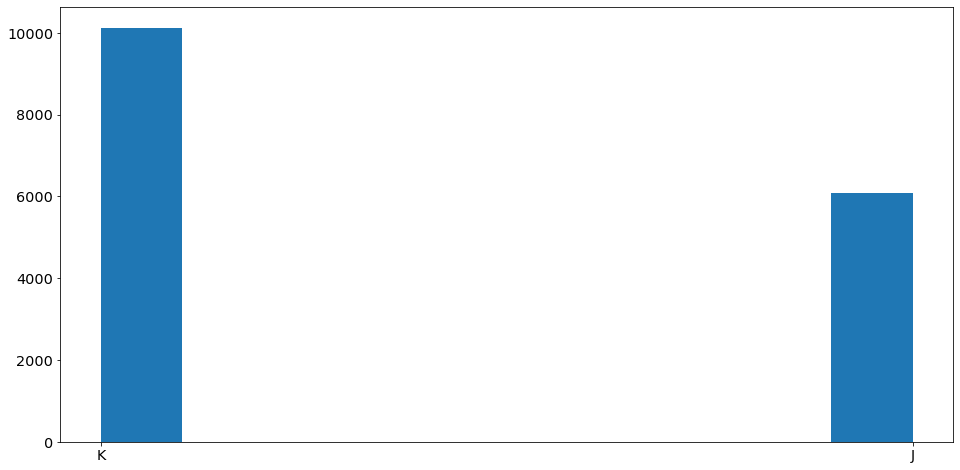

In [29]:
h = plt.hist(dados['subgrupo'])
plt.show()
# J = respiratório K = digestivo
# comparação entre os dois grupos: quase 2(d) x 1(r) -- dados desbalanceadas em termos quantitativos

## Término do preparo da base de doenças
### Escolha das features = colunas que devem ser consideradas na regressão logística - fonte = entorno02

#### Acoplamento com arquivo entorno SP02 (cidades diferentes da Capital)
#### Col: e02 [Sit_set, 206,254,260,262,264,266,268,270,272,358,360,362,364,366,368,370,372,374,376,378)]
#### chave primária deverá ser "Cod_setor", derivada do "munic_res"
#### V206 = domicílios com moradia inadequada - existe ident. logradouro
#### V254 = domicilios com moradia permanente inadequada -- existe lixo a céu aberto
#### V256 = domicilios com moradia permanente adequada -- existe lixo a céu aberto
#### V260 = domicilios com moradia permanente inadequada -- existe lixo acumulado
#### V262 = domicilios com moradia permanente até 1/4 SM
#### V264 = domicilios com moradia permanente 1/4 a 1/2 SM
#### V266 = domicilios com moradia permanente 1/2 a 1 SM
#### V268 = domicilios com moradia permanente 1 a 2 SM
#### V270 = domicilios com moradia permanente mais de 2SM
#### V272 = domicilios com moradia permanente sem rendimento nominal
#### V358 = domicilios com moradia permanente até 1/4 SM -- existe esgoto a céu aberto
#### V360 = domicilios com moradia permanente  1/4  a 1/2 SM -- existe esgoto a céu aberto
#### V362 = domicilios com moradia permanente 1/2 a 1 SM -- existe esgoto a céu aberto
#### V364 = domicilios com moradia permanente 1 a 2 SM -- existe esgoto a céu aberto
#### V366 = domicilios com moradia permanente mais de 2 SM -- existe esgoto a céu aberto
#### V368 = domicilios com moradia permanente sem rendimento nominal -- existe esgoto a céu aberto
#### V370 = domicilios com moradia permanente até 1/4 SM  --  existe lixo acumulado
#### V372 = domicilios com moradia permanente 1/4 & 1/2 SM  --  existe lixo acumulado
#### V374 = domicilios com moradia permanente 1/2 & 1 SM  --  existe lixo acumulado
#### V376 = domicilios com moradia permanente 1 & 2 SM  --  existe lixo acumulado
#### V378 = domicilios com moradia permanente mais de 2 SM  --  existe lixo acumulado
#### V380 = domicilios com moradia permanente sem rendimento  --  existe lixo acumulado

In [30]:
pd.set_option('display.max_columns', None)  

### Opção: colunas e02 

In [31]:
a=pd.read_csv(r'e02_SP2.csv', sep=";",decimal='.',encoding = 'latin', low_memory=False, error_bad_lines=False, index_col=False, nrows=8000)

In [32]:
# Preparação do código do município coerente com a base de doenças
a['Cod_setor'] = a['Cod_setor'].astype(str).str.slice(0,6)
a.rename(columns={'Cod_setor':'munic_res'}, inplace=True)
print(a.shape)
a.sample(3)

(8000, 222)


munic_res  Situacao_setor  V202  V203  V204  V205  V206  V207  V208  \
207     350060               1   115     1     0     0     0     0   115   
7516    350950               1   305    19     0     0     0     0   324   
2748    350411               2     0     0     0     0     0     0     0   

      V209  V210  V211  V212  V213  V214  V215  V216  V217  V218  V219  V220  \
207      1     0     0     0     0   113     3     0     0     0     0   113   
7516     0     0     0     0     0   324     0     0     0     0     0   324   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V221  V222  V223  V224  V225  V226  V227  V228  V229  V230  V231  V232  \
207      3     0     0     0     0   113     3     0     0     0     0    60   
7516     0     0     0     0     0   324     0     0     0     0     0   244   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V233  V234  V235  V236  V237  V238  V239  V240  V241  V242  V243  V244  \
207     56     0     0     0     0     0   116     0     0     0     0   116   
7516    80     0     0     0     0     0   324     0     0     0     0   319   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V245  V246  V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  \
207      0     0     0     0     0     0   116     0     0     0     0     0   
7516     5     0     0     0     0     0   324     0     0     0     0     0   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V257  V258  V259  V260  V261  V262  V263  V264  V265  V266  V267  V268  \
207    116     0     0     0     0     1     0     3     0    21     0    35   
7516   324     0     0     0     0     4     0    16     1    73     8   120   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V269  V270  V271  V272  V273  V274  V275  V276  V277  V278  V279  V280  \
207      1    55     0     0     0     1     0     3     0    21     0    36   
7516     4    85     6     7     0     4     0    17     0    81     0   124   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V281  V282  V283  V284  V285  V286  V287  V288  V289  V290  V291  V292  \
207      0    54     1     0     0     1     0     3     0    21     0    33   
7516     0    91     0     7     0     4     0    17     0    81     0   124   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V293  V294  V295  V296  V297  V298  V299  V300  V301  V302  V303  V304  \
207      3    55     0     0     0     1     0     3     0    21     0    33   
7516     0    91     0     7     0     4     0    17     0    81     0   124   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V305  V306  V307  V308  V309  V310  V311  V312  V313  V314  V315  V316  \
207      3    55     0     0     0     1     0     3     0    21     0    33   
7516     0    91     0     7     0     4     0    17     0    81     0   124   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V317  V318  V319  V320  V321  V322  V323  V324  V325  V326  V327  V328  \
207      3    55     0     0     0     1     0     2     1     8    13    22   
7516     0    91     0     7     0     3     1    15     2    57    24    94   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V329  V330  V331  V332  V333  V334  V335  V336  V337  V338  V339  V340  \
207     14    27    28     0     0     0     1     0     3     0    21     0   
7516    30    68    23     7     0     0     4     0    17     0    81     0   
2748     0     0     0     0     0     0     0     0     0     0     0     0   

      V341  V342  V343  V344  V345  V346  V347  V348  V349  V350  V351  V352  \
207     36     0    55     0     0     1     0     3     0    21     0    36   
7516   12

In [33]:
a.info(verbose=True)
# munic_res = "object"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 222 columns):
munic_res         object
Situacao_setor    int64
V202              int64
V203              int64
V204              int64
V205              int64
V206              int64
V207              int64
V208              int64
V209              int64
V210              int64
V211              int64
V212              int64
V213              int64
V214              int64
V215              int64
V216              int64
V217              int64
V218              int64
V219              int64
V220              int64
V221              int64
V222              int64
V223              int64
V224              int64
V225              int64
V226              int64
V227              int64
V228              int64
V229              int64
V230              int64
V231              int64
V232              int64
V233              int64
V234              int64
V235              int64
V236              int64
V23

### Seleção de colunas para dataframe específico - considerar dados sociais e ambientais

In [34]:
a1 = a.loc[:, ['munic_res','Situacao_setor','V206','V254','V256','V260','V262','V264','V266','V268','V270','V272','V358','V360','V362','V364','V366','V368','V370','V372','V374','V376','V378','V380']]

In [35]:
a1.head(2)

munic_res  Situacao_setor  V206  V254  V256  V260  V262  V264  V266  V268  \
0    350011               1     0     0     0     0     0     1    22    42   
1    350011               1     0     0     0     0     0    15    59    87   

   V270  V272  V358  V360  V362  V364  V366  V368  V370  V372  V374  V376  \
0    79     3     0     0     0     0     0     0     0     0     0     0   
1    91     4     0     0     0     0     0     0     0     0     0     0   

   V378  V380  
0     0     0  
1     0     0

## Seleção de algumas colunas apenas -- redução do número de features

In [36]:
a1 = a.loc[:, ['munic_res','Situacao_setor','V262','V264','V266','V268','V270','V272']]

## Junção das duas bases de dados -- doenças (SIH) & entorno02. Uso da função "merge"

In [37]:
mg = pd.merge(dados,a1,on='munic_res', how='inner')
# junção dos arquivos, naquilo que for comum aos dois, pelo "munic_res"

In [38]:
mg.info(verbose=True)
# nr de linhas muito maior do que esperado, pode haver duplicação desnecessária

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478111 entries, 0 to 478110
Data columns (total 10 columns):
munic_res         478111 non-null object
diag_princ        478111 non-null object
subgrupo          478111 non-null object
Situacao_setor    478111 non-null int64
V262              478111 non-null int64
V264              478111 non-null int64
V266              478111 non-null int64
V268              478111 non-null int64
V270              478111 non-null int64
V272              478111 non-null int64
dtypes: int64(7), object(3)
memory usage: 40.1+ MB


In [39]:
mg.drop_duplicates(inplace=True)
# retirada de duplicações eventuais

In [40]:
mg.dropna

<bound method DataFrame.dropna of        munic_res diag_princ subgrupo  Situacao_setor  V262  V264  V266  V268  \
0         350850       K409        K               1     0     1     7    18   
1         350850       K409        K               1     2    10    43    67   
2         350850       K409        K               1     8     7    39    51   
3         350850       K409        K               1     5    17    42    46   
4         350850       K409        K               1     2     8    28    73   
...          ...        ...      ...             ...   ...   ...   ...   ...   
478100    350110       J188        J               1     1    17    84    62   
478101    350110       J188        J               3     0     0     0     0   
478102    350110       J188        J               8     0     0     0     0   
478107    350110       J188        J               1     7    37    78    25   
478109    350110       J188        J               1     5    11    31    17   

     

In [41]:
mg.astype({'munic_res': 'int32'}).dtypes
# alteração do munic_res para int32

munic_res          int32
diag_princ        object
subgrupo          object
Situacao_setor     int64
V262               int64
V264               int64
V266               int64
V268               int64
V270               int64
V272               int64
dtype: object

In [42]:
mg.isnull().sum().sum()

0

In [43]:
mg.isna().values.sum()

0

### Base de dados pronta. Fim da preparação de arquivo para Regressões.

## XGBoost_desenvolvimento para regressão logística -- doenças J ou K

### importação_bibliotecas_específicas

In [44]:
! pip install lightgbm
! pip install xgboost

### divisão_X(entrada=features)_y(saída=subgrupo, somente com J ou K)

In [45]:
y = mg.loc[:,'subgrupo'] # variável a ser predita, ou variável explicada
X = mg.drop(['diag_princ','subgrupo'], axis=1) 

In [70]:
X.shape, y.shape

((194729, 8), (194729,))

In [46]:
from sklearn.model_selection import train_test_split

In [71]:
# preparação do array de saída 'y'
from sklearn import preprocessing
le = preprocessing.LabelBinarizer()
y = le.fit_transform(y)
y = np.ravel(y)

In [72]:
# Divisão entre treino e teste
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

In [73]:
X_train.shape, y_train.shape

((136310, 8), (136310,))

In [74]:
X_test.shape, y_test.shape

((58419, 8), (58419,))

In [77]:
194729 * 0.3

58418.7

In [76]:
136310 + 58419

194729

### Avaliação das features_ uso do Extra Tree Classifier -- método em árvore de decisão

In [51]:
# número máximo de features = 10 -- primeira avaliação, pode ser maior ou menor.
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [53]:
print(model.feature_importances_)
# temos 8 variáveis explicativas -- coefiencientes de correlação, que são baixos todavia. Rever então - depois.

[0.4342322  0.00718122 0.07474354 0.09450663 0.10983833 0.09584192
 0.11130118 0.07235497]


<AxesSubplot:>

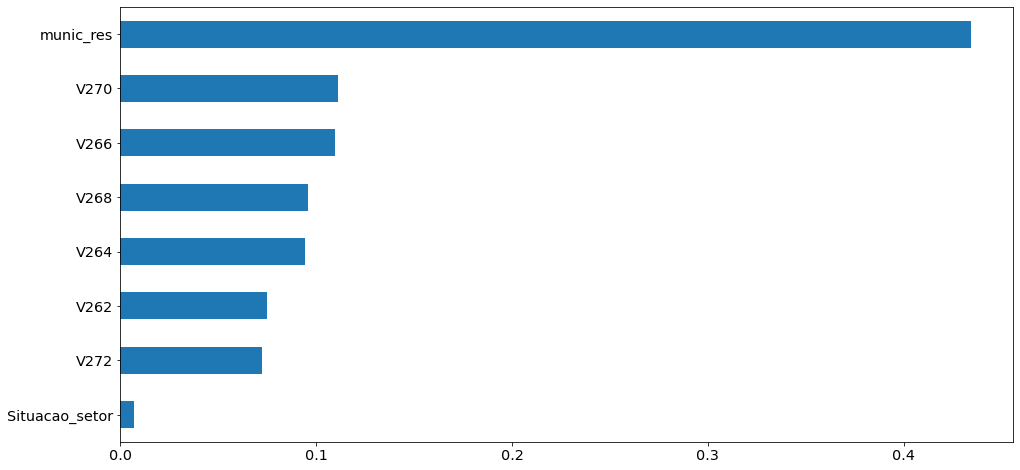

In [54]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(8).sort_values().plot.barh())
# apresentação das features por importância - para se escolher quais devem permanecer

In [80]:
# seleção de algumas variáveis, escolhendo as colunas que nos interessam para prosseguir. 
x0=X.iloc[:,0]
x1=X.iloc[:,1]
x2=X.iloc[:,2]
x3=X.iloc[:,3]
x4=X.iloc[:,4]
x5=X.iloc[:,5]
x6=X.iloc[:,6]
xnew=np.column_stack((x0,x1,x2,x3,x4,x5,x6))
xnew
# xnew = novos dados de entrada, somente com as colunas selecionadas depois da avaliação.
# feito um novo dataframe somente com as colunas selecionadas.
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(xnew,y,test_size =0.3,random_state=0)
# x_val & y_val = novos conjuntos de dados para teste

In [81]:
xnew.shape, y.shape

((194729, 7), (194729,))

In [82]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((136310, 7), (58419, 7), (136310,), (58419,))

## Comparação entre Regressão Logística (probabilidades) x BoostingClassifiers(árvores de decisão combinadas)

### Seleção dos parâmetros de cada método de Boosting (combinação de árvores de decisão)
### Uso somente na parcela de 'treino' -- fit com os dados separados

In [83]:
# Logistic Regression -- método clássico com probabilidade
# não há parâmetros para selecionar ou ajustar.
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression().fit(x_train,y_train)
logreg

# GradientBoostingClassifier -- método de árvore de decisão com análise de gradiente(variação) da função de mérito
# não há parâmetros para selecionar ou ajustar
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(x_train, y_train)

#  LightGBM Classifier -- outro método de árvore combinada, mais simples
# aqui há parâmetros para ajustar: learning_rate, num_leaves, n_estimators
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb_model.fit(x_train, y_train)

# XGBoost -- método mais completo de combinação de árvores de decisão
# idem acima, temos parâmetros para ajustar
import xgboost as xgb
xgb_model = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb_model.fit(x_train, y_train)

# AdaBoost -- método alternativo de combinação de árvores de decisão
# temos termos para ajustar
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.001)
ada_clf.fit(x_train, y_train)

print('*****************ClassifiersDone*****************')

C:\Users\aferr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



*****************ClassifiersDone*****************


### Uso de dados de treino. Pontuações Obtidas depois da comparação. 'Score' considera acurácia.

In [84]:
# Fase de treino apenas, uso de todos os modelos
models=['Logistic','GradientBoost','LightGBM','XGBoost','AdaBoost']
Trainning_Accuracy=[logreg.score(x_train,y_train),
                    gbrt.score(x_train, y_train),
                    lgb_model.score(x_train, y_train),
                    xgb_model.score(x_train, y_train), 
                    ada_clf.score(x_train, y_train)]
# training accuracy: uso de todos os dados iniciais.

Validation_Accuracy=[logreg.score(x_val, y_val),
                    gbrt.score(x_val, y_val),
                    lgb_model.score(x_val, y_val),
                    xgb_model.score(x_val, y_val), 
                    ada_clf.score(x_val, y_val)]
# validation accuracy: uso dos dados selecionados pela importância apurada com o Extra Tree Classifier
pd.DataFrame(list(zip(Trainning_Accuracy, Validation_Accuracy)), 
                  columns =['Trainning_Accuracy', 'Validation_Accuracy'],
                  index=models)

Trainning_Accuracy  Validation_Accuracy
Logistic                 0.673069             0.673462
GradientBoost            0.676649             0.675859
LightGBM                 0.673069             0.673462
XGBoost                  0.673069             0.673462
AdaBoost                 0.673069             0.673462

In [85]:
# Preparação dos dados para ter distribuição com média = 0 e desvio padrão = 1
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
sc.fit(X_train)
X_train_st = sc.transform(X_train) 
X_test_st = sc.transform(X_test)

In [86]:
X_train.shape, X_train_st.shape, X_test_st.shape

((136310, 8), (136310, 8), (58419, 8))

In [87]:
y_train.shape, y_test.shape,

((136310,), (58419,))

### REGRESSÂO LOGÍSTICA -- matriz de confusão 

In [89]:
def CMatrix(CM,labels =['J','K']):
    df = pd.DataFrame( data = CM, index = labels, columns = labels)
    df.index.name ='Real'
    df.columns.name = 'Previsto'
    df.loc['Total']= df.sum()
    df['Total']= df.sum(axis=1)
    return df 

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix

In [91]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state=1234, solver = 'lbfgs')
log.fit(X_train_st,y_train)
log_pred = log.predict(X_test_st)
log_cm = confusion_matrix(y_test,log_pred)

acuracia_log = accuracy_score(y_pred=log_pred,y_true=y_test)
precisao_log = precision_score(y_pred=log_pred,y_true=y_test)
recall_log = recall_score(y_pred=log_pred,y_true=y_test)

In [95]:
def Tabela (metrica):
    dataset = pd.DataFrame(data = metrica,
                      columns = ['Acurácia','Precisão','Revocação-Recall'],
                      index = ['Gradient Boost'])
    return dataset 

In [96]:
metrica = [(acuracia_log, precisao_log , recall_log)]
Tabela(metrica)

Acurácia  Precisão  Revocação-Recall
Gradient Boost  0.672983  0.672983               1.0

In [98]:
CM= confusion_matrix(y_pred=log_pred,y_true=y_test)
CMatrix(CM).T

Real          J      K  Total
Previsto                     
J             0      0      0
K         19104  39315  58419
Total     19104  39315  58419

### GRADIENT BOOST CLASSIFIER -- matriz de confusão

In [99]:
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(X_train_st, y_train)
grbt_pred=grbt.predict(X_test_st)
grbt_cm=confusion_matrix(y_test,grbt_pred)
acuracia_grbt = accuracy_score(y_pred=grbt_pred,y_true=y_test)
precisao_grbt = precision_score(y_pred=grbt_pred,y_true=y_test)
recall_grbt = recall_score(y_pred=grbt_pred,y_true=y_test)

In [102]:
metrica = [(acuracia_grbt, precisao_grbt , recall_grbt)]
Tabela(metrica)

Acurácia  Precisão  Revocação-Recall
Gradient Boost     0.673  0.673012          0.999924

In [103]:
CM= confusion_matrix(y_pred=grbt_pred,y_true=y_test)
CMatrix(CM).T

Real          J      K  Total
Previsto                     
J             4      3      7
K         19100  39312  58412
Total     19104  39315  58419

### EXTREME GRADIENT BOOST CLASSIFIER XGBOOST -- matriz de confusão

In [104]:
xgboost = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgboost.fit(X_train_st, y_train)
xgboost_pred=grbt.predict(X_test_st)
xgboost_cm=confusion_matrix(y_test,xgboost_pred)
acuracia_xgboost = accuracy_score(y_pred=xgboost_pred,y_true=y_test)
precisao_xgboost = precision_score(y_pred=xgboost_pred,y_true=y_test)
recall_xgboost = recall_score(y_pred=xgboost_pred,y_true=y_test)

In [105]:
metrica = [(acuracia_xgboost, precisao_xgboost , recall_xgboost)]
Tabela(metrica)

Acurácia  Precisão  Revocação-Recall
Gradient Boost     0.673  0.673012          0.999924

In [106]:
CM= confusion_matrix(y_pred=xgboost_pred,y_true=y_test)
CMatrix(CM).T

Real          J      K  Total
Previsto                     
J             4      3      7
K         19100  39312  58412
Total     19104  39315  58419

## Conclusão = o XGBoost melhora um pouco a acurácia em relação à Regressão Logística, mas são da mesma ordem de grandeza. Os parãmetros do XGBoost demandam revisão.